In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo
import psi4
import v3d

In [ ]:
psi4.core.set_output_file('bonds.dat')
theory = 'mp2/6-31G*'
bohr2ang = 0.529177
rad2deg = 180.0/np.pi
psi4.set_memory('2gb')

In [ ]:
#optimized coordinates of the molecules
azi = """
0 1
    C           -1.372186183321    -2.010860020902    -0.886820192828
    C           -0.173158673000    -1.298344357907    -0.406115006426
    N            0.786309071860    -1.384810968974     0.420697487368
    C            0.662837700048    -0.111043752576    -0.491918176988
    H            1.422532833369    -0.002132476819    -1.261568419806
    C            0.271415655367     1.154529325936     0.168585840901
    O           -0.638034693748     0.950769479245     1.162558403008
    O            0.686902544636     2.258017066085    -0.144478115352
    H           -1.457401352716    -2.978238526949    -0.387585199421
    H           -1.313874303487    -2.157164437091    -1.968871402470
    H           -2.260422649854    -1.409349289546    -0.673788389312
    H           -0.815494634684     1.839688017493     1.533442847642
"""


In [ ]:
#what coordinates are we optimizing
coords = [
    (2, 4),
    (6, 4),
    (4, 3)
]

opt_coords = np.zeros(len(coords))
#print the optimized values of these coordinates:
#also, save these values for later
azi_geo = psi4.geometry(azi)
for item, pair in enumerate(coords):
    opt_coords[item] = v3d.dist((azi_geo.to_arrays()[0])[pair[0]-1],
                 (azi_geo.to_arrays()[0])[pair[1]-1])*bohr2ang
    print(opt_coords[item])

opt_energy = psi4.energy(theory)

In [ ]:
#collecting real optimized coordinate values here. 
#these wont always be the same as the values in r
#because of "fixed" rather than "frozen" coordinate scan
r_real = np.zeros((len(coords), 15))
#collecting energies here
energies = np.zeros((len(coords), 15))
    
for item, pair in enumerate(coords):
    
    #define geometry
    azi_geo = psi4.geometry(azi)
    #get optimized coordinate values
    r0 = v3d.dist((azi_geo.to_arrays()[0])[pair[0]-1],
                  (azi_geo.to_arrays()[0])[pair[1]-1])*bohr2ang
    
    #increased coordinate value half of scan
    rplus = np.linspace(r0, r0+0.15, 8)
    #decreased coordinate value half of scan
    rminus = np.linspace(r0-0.15, r0, 8)[:-1]
    #putting them together
    r = np.append(rminus, rplus)
        
    azi_geo = psi4.geometry(azi)
    #selecting left half. This set up 
    #lets the optimization start with the optimized
    #coordinates, then move away from them
    #hence, np.flip.
    for i, n in enumerate(np.flip(rminus)):#r):
        #options for geometry opt
        options={'scf_type':'df',
             'g_convergence':'gau_loose',
             'freeze_core':'true',
             'opt_coordinates':'both',
             #selecting atoms I care about and target distance
             "ranged_distance":"{a} {b} {c} {d}".format(a=pair[0], 
                                                   b=pair[1], 
                                                   c=n-0.005,
                                                   d=n+0.005),
             "geom_maxiter" : 200,
             #"full_hess_every" : 20,
             "dynamic_level" : 0}
        psi4.set_options(options)
        energies[item, 6-i] = psi4.optimize(theory)
        r_real[item, 6-i] = v3d.dist((azi_geo.to_arrays()[0])[pair[0]-1],
                               (azi_geo.to_arrays()[0])[pair[1]-1])*bohr2ang
        print(np.abs(r_real[item, 6-i] - n))
            
    azi_geo = psi4.geometry(azi)
    #generally the same as above but for the above half of the scan
    for i, n in enumerate(rplus):#r):
        options={'scf_type':'df',
             'g_convergence':'gau_loose',
             'freeze_core':'true',
             'opt_coordinates':'both',
             "ranged_distance":"{a} {b} {c} {d}".format(a=pair[0], 
                                                   b=pair[1], 
                                                   c=n-0.005,
                                                   d=n+0.005),             
             "geom_maxiter" : 200,
             #"full_hess_every" : 20,
             "dynamic_level" : 0}
        psi4.set_options(options)
        energies[item, 7+i] = psi4.optimize(theory)
        r_real[item, 7+i] = v3d.dist((azi_geo.to_arrays()[0])[pair[0]-1],
                               (azi_geo.to_arrays()[0])[pair[1]-1])*bohr2ang
        print(np.abs(r_real[item, 7+i] - n))

In [6]:
energies

array([[-359.52619119, -359.52822023, -359.52994093, -359.53135107,
        -359.53244832, -359.53323402, -359.5337088 , -359.5338743 ,
        -359.53371854, -359.53328808, -359.532588  , -359.5316246 ,
        -359.53040384, -359.52893434, -359.5272254 ],
       [-359.52599031, -359.52808932, -359.52986162, -359.53130711,
        -359.532427  , -359.53322465, -359.53370224, -359.5338743 ,
        -359.53371269, -359.53328466, -359.53259024, -359.53164056,
        -359.53044581, -359.52901736, -359.52736746],
       [-359.52869496, -359.5301546 , -359.53135733, -359.53231222,
        -359.53302945, -359.53352023, -359.53379558, -359.5338743 ,
        -359.53380029, -359.53355962, -359.53315998, -359.53261329,
        -359.53193017, -359.53112115, -359.53019628]])

In [14]:
energies_norm = (energies-opt_energy)*627.503

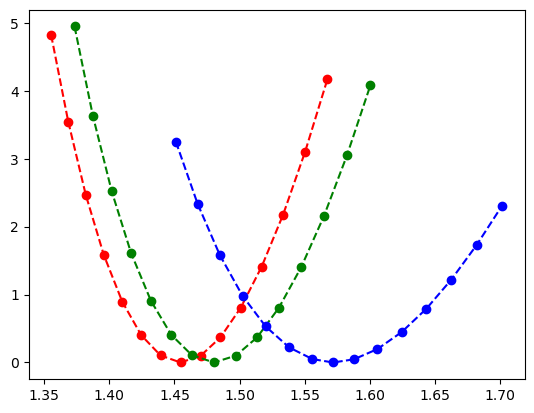

In [17]:
#collected data plots
colors = ['r', 'g', 'b']

for i in range(len(coords)):
               plt.plot(r_real[i], energies_norm[i], '--o', color=colors[i]) 
               #plt.ylim(0, 10)
               #plt.xlim(1.0, 2)

In [18]:
def vbond(r, k, r0):
    return k*(r-r0)**2

In [19]:
parms = []
                 
for i in range(len(coords)):
    parms.append(spo.curve_fit(vbond, 
                               r_real[i], 
                               energies_norm[i], 
                               p0=[300, 1.5]))

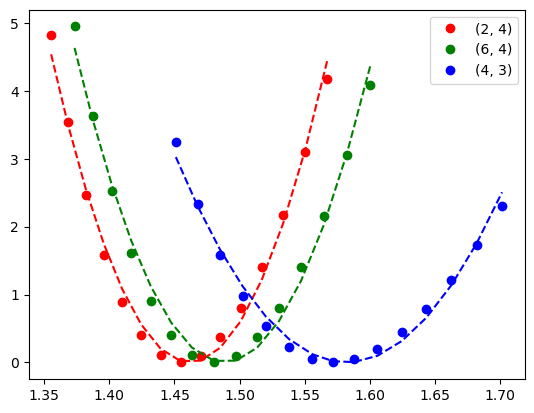

In [20]:
#fitted data plots
colors = ['r', 'g', 'b']

for i in range(len(coords)):
    plt.plot(r_real[i], energies_norm[i], 'o', color=colors[i], label=str(coords[i])) 
    plt.plot(r_real[i], vbond(r_real[i], *parms[i][0]), '--', color=colors[i])
plt.legend()
#plt.ylim(0, 50)
#plt.xlim(1.0, 2)

In [21]:
for i in range(len(coords)):
    print('For the bond between atoms ', str(coords[i]))
    print('the force constant is ', str(parms[i][0][0]), ' p/m ', np.sqrt(np.diag(parms[i][1]))[0], 'kcal/mol/A^2')
    print('and the optimal bond length is ', str(parms[i][0][1]), ' p/m ', np.sqrt(np.diag(parms[i][1]))[1], 'A')


For the bond between atoms  (2, 4)
the force constant is  399.80038323466675  p/m  7.812794094971214 kcal/mol/A^2
and the optimal bond length is  1.4618410634534853  p/m  0.0008567026547830041 A
For the bond between atoms  (6, 4)
the force constant is  349.0833299504062  p/m  7.265556687649437 kcal/mol/A^2
and the optimal bond length is  1.4884604882114454  p/m  0.000978204288151474 A
For the bond between atoms  (4, 3)
the force constant is  176.02002731010714  p/m  4.217909186537254 kcal/mol/A^2
and the optimal bond length is  1.5821277809840957  p/m  0.0012516459212414698 A
